# GAN

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
from tqdm import trange

SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 28
IMG_W = 28
IMG_C = 1
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 5000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

DC_LR = 2.5e-04
DC_EPOCH = 256

W_LR = 2.0e-04
W_EPOCH = 256
WClipLo = -0.01
WClipHi = 0.01

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the specified GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
!nvidia-smi

Sat Dec 18 16:23:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P2    62W / 250W |    284MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

## DCGAN
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
    * Each convolutional layer halved the feature maps resolution. (Not hard requirement.)
* Use batch normalization in both the generator and the discriminator.
    * The batch normalization here is the simplest one just normalizing the feature activations.
    * Do not use batch normalization in the last few layers in generator, since it may make it difficult for generator to fit the variance of real data. For example, if the mean of data is not zero, and we use batchnorm and tanh in the last layer of G, then it will never match the true data distribution.
* Use ReLU activation in generator for all layers except for the output, which uses tanh or sigmoid.
    * Depends on the range of real data.
* Use LeakyReLU activation in the discriminator for all layers.
    * LeakyReLu is recommened by AllConvNet approach for faster training.

In [4]:
# Load images, discard labels
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

iTrain = train_images.reshape(-1, 28, 28, 1).astype(np.float32)

# Normalizing the images to the range of [0., 1.]
iTrain = iTrain / 255.0

dsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(BATCH_SIZE, drop_remainder=True)

# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

### Model

In [5]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [13]:
DC_G, DC_D = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(DC_LR)
optimizer_d = keras.optimizers.Adam(DC_LR)

cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def DC_G_Loss(c0):
    """
    c0: logits of fake images
    """
    return cross_entropy(tf.ones_like(c0), c0)

def DC_D_Loss(c0, c1):
    """
    c0: logits of fake images
    c1: logits of real images
    """
    l1 = cross_entropy(tf.ones_like(c1), c1)
    l0 = cross_entropy(tf.zeros_like(c0), c0)
    return l1 + l0

@tf.function
def DC_D_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

        z0 = DC_D(c0, training = True)
        z1 = DC_D(c1, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_d = tp.gradient(ld, DC_D.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, DC_D.trainable_variables))
    
    return lg, ld

@tf.function
def DC_G_Train(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tp:
        c0 = DC_G(z, training = True)

       
        z1 = DC_D(c1, training = True)
        z0 = DC_D(c0, training = True)

        lg = DC_G_Loss(z0)
        ld = DC_D_Loss(z0, z1)

    gradient_g = tp.gradient(lg, DC_G.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, DC_G.trainable_variables))
    
    return lg, ld

In [14]:
# ratio of training step D:G = 5:1
DCTrain = (
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_G_Train
)

DCCritic = len(DCTrain)

Generator Initial Output :


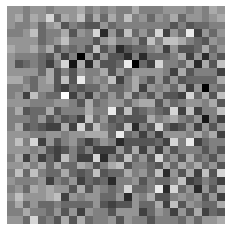

Discriminator Initial Output : 3.770167E-02


In [9]:
print("Generator Initial Output :")
c0 = DC_G(tf.random.normal((1, Z_DIM)), training = False)
plt.imshow((c0[0, :, :, 0] * 255.0).numpy().astype(np.uint8), cmap = "gray")
plt.axis("off")
plt.show()
print("Discriminator Initial Output : %E" % DC_D(c0).numpy())

### Training

 12%|█▏        | 31/256 [01:18<09:16,  2.47s/it]

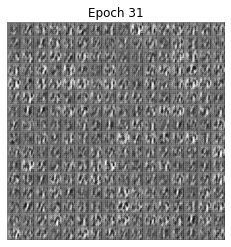

 25%|██▍       | 63/256 [02:37<07:59,  2.49s/it]

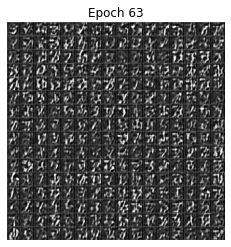

 37%|███▋      | 95/256 [03:57<06:40,  2.49s/it]

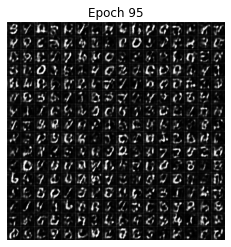

 50%|████▉     | 127/256 [05:17<05:24,  2.52s/it]

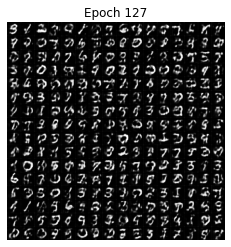

 62%|██████▏   | 159/256 [06:39<04:08,  2.56s/it]

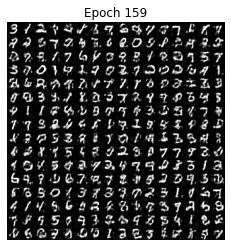

 75%|███████▍  | 191/256 [08:02<02:47,  2.58s/it]

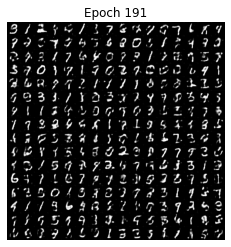

 87%|████████▋ | 223/256 [09:25<01:25,  2.60s/it]

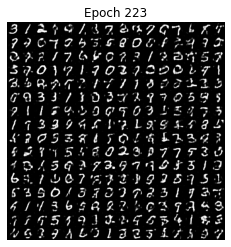

100%|█████████▉| 255/256 [10:48<00:02,  2.59s/it]

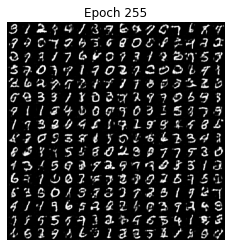

100%|██████████| 256/256 [10:50<00:00,  2.54s/it]


In [15]:
dc_lg = [None] * DC_EPOCH #record loss of g for each epoch
dc_ld = [None] * DC_EPOCH #record loss of d for each epoch
dc_sp = [None] * DC_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in trange(DC_EPOCH):
    loss_g_t = 0.0
    loss_d_t = 0.0
    for batch in dsTrain:
        loss_g, loss_d = DCTrain[ctr](batch)
        ctr += 1
        loss_g_t += loss_g.numpy()
        loss_d_t += loss_d.numpy()
        if ctr == DCCritic : ctr = 0
    dc_lg[ep] = loss_g_t * rsTrain
    dc_ld[ep] = loss_d_t * rsTrain
    
    out = DC_G(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/dc_%04d.png" % ep
    )
    dc_sp[ep] = img
    if (ep + 1) % 32 == 0:
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [16]:
utMakeGif(np.array(dc_sp), "imgs/dcgan.gif", duration = 2)

t:   3%|▎         | 7/256 [00:00<00:03, 68.25it/s, now=None]

MoviePy - Building file imgs/dcgan.gif with imageio.


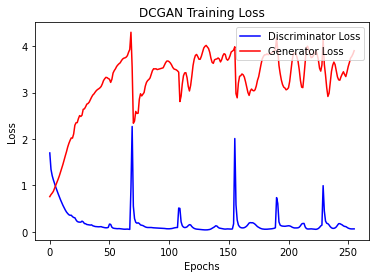

In [17]:
plt.plot(range(DC_EPOCH), dc_ld, color = "blue", label = "Discriminator Loss")
plt.plot(range(DC_EPOCH), dc_lg, color = "red",  label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DCGAN Training Loss")
plt.show()

## Wasserstein GAN

In [6]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.RMSprop(W_LR)
optimizer_d = keras.optimizers.RMSprop(W_LR)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)

        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)

    gradient_d = tpd.gradient(ld, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))
    # clipping
    for v in WD.trainable_variables: 
        v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

In [7]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

 12%|█▏        | 31/256 [01:21<09:26,  2.52s/it]

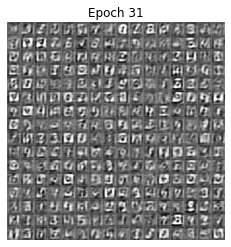

 25%|██▍       | 63/256 [02:43<08:20,  2.59s/it]

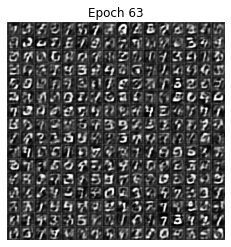

 37%|███▋      | 95/256 [04:06<06:53,  2.57s/it]

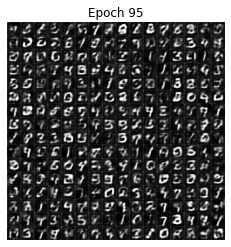

 50%|████▉     | 127/256 [05:32<06:07,  2.85s/it]

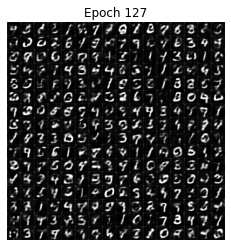

 62%|██████▏   | 159/256 [07:01<04:32,  2.81s/it]

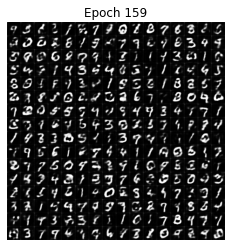

 75%|███████▍  | 191/256 [08:35<03:05,  2.86s/it]

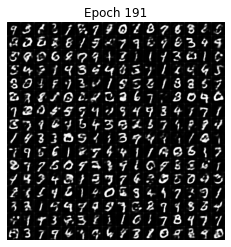

 87%|████████▋ | 223/256 [10:11<01:37,  2.97s/it]

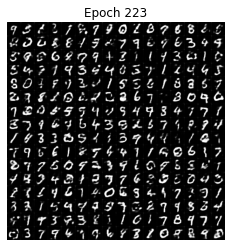

100%|█████████▉| 255/256 [11:46<00:02,  2.99s/it]

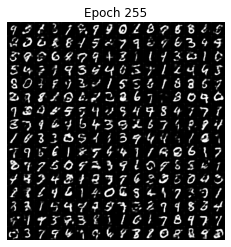

100%|██████████| 256/256 [11:49<00:00,  2.77s/it]


In [8]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch

rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in trange(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/wgan/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [9]:
utMakeGif(np.array(wsp), "imgs/wgan/wgan.gif", duration = 2)

t:   2%|▏         | 6/256 [00:00<00:04, 56.66it/s, now=None]

MoviePy - Building file imgs/wgan/wgan.gif with imageio.


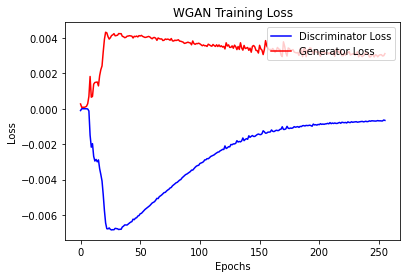

In [10]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()